# Project 1. Анализ оттока клиентов банка.
Использована открытая база данных с сайта Kaggle.com (https://www.kaggle.com/datasets/mathchi/churn-for-bank-customers)

Столбцы таблицы:
* RowNumber — номер строки таблицы (это лишняя информация, поэтому можете сразу от неё избавиться)
* CustomerId — идентификатор клиента
* Surname — фамилия клиента
* CreditScore — кредитный рейтинг клиента (чем он выше, тем больше клиент брал кредитов и возвращал их)
* Geography — страна клиента (банк международный)
* Gender — пол клиента
* Age — возраст клиента
* Tenure — сколько лет клиент пользуется услугами банка
* Balance — баланс на счетах клиента в банке
* NumOfProducts — количество услуг банка, которые приобрёл клиент
* HasCrCard — есть ли у клиента кредитная карта (1 — да, 0 — нет)
* IsActiveMember — есть ли у клиента статус активного клиента банка (1 — да, 0 — нет)
* EstimatedSalary — предполагаемая заработная плата клиента
* Exited — статус лояльности (1 — ушедший клиент, 0 — лояльный клиент)

In [1]:
# import main librariees
import pandas as pd
import numpy as np #для матричных вычислений
import os, sys

# Graphical libraries
import matplotlib.pyplot as plt 
import seaborn as sns 
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline
plt.style.use('fast')


# ML libraries
from sklearn import linear_model, metrics, preprocessing, tree, ensemble
from sklearn.model_selection import train_test_split 

# set random seed
random_seed = 42

#set path
sys.path.insert(1, '../')

In [2]:
#Исследуем массив данных об оттоке клиентов некоторого банка. 
churn_data = pd.read_csv('../data/churn.zip', sep=',') 

# Копируем таблицу, чтобы не испортить оригинальный массив данных
churn_df = churn_data.copy()

# RowNumber — номер строки таблицы (это лишняя информация, поэтому можем сразу от неё избавиться)
churn_df.drop(['RowNumber'], axis=1, inplace=True) 

#Создадим графу 'client status' для наглядного отображения статуса пользования банком
churn_df['client status'] = churn_df['Exited'].astype('category').cat.rename_categories({0:'Клиент', 1:'Покинул банк'})

churn_df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,client status
0,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,Покинул банк
1,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,Клиент
2,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,Покинул банк
3,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,Клиент
4,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,Клиент


# Задание 9.1. 
----------
Каково соотношение ушедших и лояльных клиентов? Покажите это на графике и дайте комментарий по соотношению.

In [3]:
#данные
df=churn_df['client status'].value_counts().sort_values(ascending=False)

fig = px.pie(
    data_frame = df,
    values = 'client status',
    names = df.index,
    width=500, height=400,
    title='Рис.1 - Распределение клиентов по лояльности',
)

fig.update_layout(
    legend_title_text='Статус лояльности:'
)
#fig.update_traces(textposition='inside', textinfo='percent+label')
#fig.show();

fig.write_image('../figures/fig_1.png', engine="kaleido")

<center> <img src = "../figures/fig_1.png"></center>

На рис.1 изображена круговая диаграмма распределения клиентов в зависимости от лояльности. В базе данных имеется: 10000 клиентов. Пользуются услугами банка 79,6 % или 7963 чел. Обозначенная оранжевым часть клиентов в 20,4 % или 2037 чел. покинула банк. 

# Задание 9.2. 
---------- 
Постройте график, показывающий распределение баланса пользователей, у которых на счету больше 2 500 долларов. Опишите распределение и сделайте выводы.


In [4]:
fig = px.box(
    data_frame = churn_df[churn_df['Balance'] > 2500],
    x = 'Balance',
    height=250, width=700, 
)

fig.update_layout(
    title=dict(text='Рис.2 - распределение балансов клиентских счетов, <br>превышающие 2500 долларов', x=.5, xanchor='center'),
    xaxis_title_text = 'Баланс клиентов, доллар', yaxis_title_text = 'Клиенты <br> банка'
)

#fig.show()
fig.write_image('../figures/fig_2.png', engine="kaleido")

<center> <img src = "../figures/fig_2.png">

На рис.2 изображено распределение балансов клиентских счетов, превосходящие 2500 долларов.
* В базе содержится 6383 клиента с таким остатоком на счету. Примерно половина из них (3250 клиента) имеют от 100 тыс. до 140 тыс. долларов на счету.
* Распределение баланса клиентского счета симметрично относительно среднего значения около 119827 долларов со стандартным отклонением около 30095 долларов. Медианный остаток составляет около 119840 долларов. 
* Половина клиентов имеет на счету средства, величина которых находится в относительно узком диапазоне. Межквартильный размах (IQR) составляет 39330 доллара. Границы распределения (диапазона) определим по формуле: нижняя граница Q25 - 1,5*IQR = 100182 - 1.5*39330 = 41187 долларов; верхняя граница Q75 + 1.5*IQR = 139512 + 1.5*39330 = 198507 долларов. 
* Минимальный остаток на счету составляет 3769 долларов, а максимальный 250898 долларов.
* Распределение данных близко к нормальному.

# Задание 9.3. 
---------- 
Посмотрите на распределение баланса клиента в разрезе признака оттока. Как различаются суммы на накопительном счёте ушедших и лояльных клиентов? Подумайте и напишите, с чем это может быть связано, что может не устраивать ушедших клиентов в банке.

In [5]:
#блочная диаграмма с помощью библиотеки Plotly

fig = px.box(
    data_frame = churn_df,
    x = 'Balance',
    y = 'client status',
    color = 'client status',
    height=300, width=800, 
)
fig.update_layout(
    title=dict(text='Рис.3 - распределение баланса счетов <br> в зависимости от статуса использования банка', x=.5, xanchor='center'),
    xaxis_title_text = 'Баланс клиента, доллар', yaxis_title_text = 'Статус <br>клиента', legend_title_text='Статус клиента:', 
)
#fig.show()
fig.write_image('../figures/fig_3.png', engine="kaleido")

<center> <img src = "../figures/fig_3.png">

На рис.3 изображена блочная диаграмма распределения остатков на счетах клиентов в разрезе признака оттока. Анализируя диаграммы, можно сказать, что у половины из 2037 покинувших банк клиентов на счету было от 37896 до 131435 долларов с медианным остатком около 109349 долларов. У половины оставшихся клиентов баланс составляет от 0 до 126419 долларов с медианным остатком около 92072 доллара. Такое различие между распределениями статка счёта позволяет сделать вывод о целях использования счетов клиентами: 
* большая часть ушедших клиентов хранила значительные суммы на счетах;
* текущие клиенты банка чаще используют счёт для текущих расходов и имеют меньший остаток, чем ушедшие клиенты.


# Задание 9.4. 
----------
Посмотрите на распределение возраста в разрезе признака оттока. В какой группе больше потенциальных выбросов? На какую возрастную категорию клиентов стоит обратить внимание банку?

In [6]:
#блочная диаграмма с помощью библиотеки Plotly
fig = px.box(
    data_frame = churn_df,
    x = 'Age',
    y = 'client status',
    color = 'client status',
    width=800, height=300,
)
fig.update_layout(
    title=dict(text='Рис. 4 - Распределение возраста ушедших клиентов <br>в разрезе признака оттока', x=.5, xanchor='center'),
    xaxis_title_text = 'Возраст клиента, лет', yaxis_title_text = 'Статус <br>клиента',  
    legend_title_text='Статус клиента:'
)
#fig.show()
fig.write_image('../figures/fig_4.png', engine="kaleido")

<center> <img src = "../figures/fig_4.png">

На рис.4 изображена блочная диаграмма распределения возратса клиентов в разрезе статуса использования банка. Анализируя диаграмму, можно сделать следующие выводы:
* больше всего выбросов данных в распределении возраста текущих клиентов банка. Медианный возраст клиентов составляет 36 лет. Однако, часто встречаются клиенты старше 57 лет;
* меньше всего выбросов в распределении покинувших банк клиентов. Их медианный возраст составляет 45 лет. Выбросы встречаются снаружи границ распределения - т.е. менее 18 лет либо более 72 лет. Половина ушедших клиентов была в возрасте от 38 до 51 года. Именно на эту групу клиентов следует обратить внимание менеджерам банка.

# Задание 9.5. 
----------
Постройте график, который показывает взаимосвязь кредитного рейтинга клиента и его предполагаемой зарплаты. Добавьте расцветку по признаку оттока клиентов. Какова взаимосвязь между признаками? Если не видите явной взаимосвязи, укажите это.

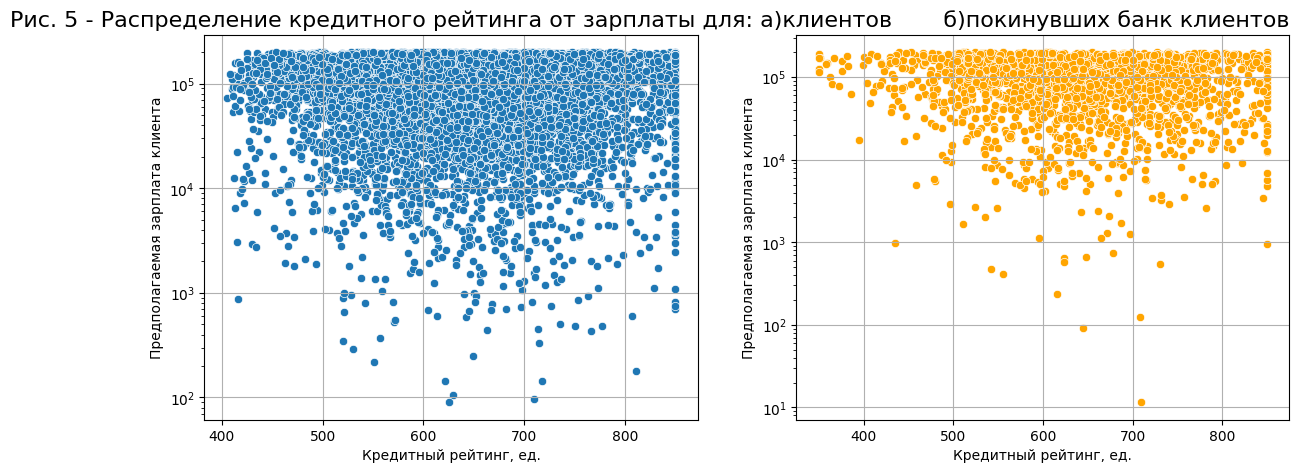

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

# построим диаграммы рассеяния с помощью библиотеки Seaborn
sns.scatterplot(
    data=churn_df[churn_df['client status'] == 'Клиент'],
    x='CreditScore',
    y='EstimatedSalary', #marker="+",
    ax=axes[0]    
    ); 
# логарифмическая шкала по оси У
axes[0].set(yscale="log") #xscale="log"

axes[0].set_title('Рис. 5 - Распределение кредитного рейтинга от зарплаты для: а)клиентов', fontsize=16)
axes[0].set_xlabel('Кредитный рейтинг, ед.')
axes[0].set_ylabel('Предполагаемая зарплата клиента')
axes[0].grid();

#Диаграмма рассеяния 2 
sns.scatterplot(
    data=churn_df[churn_df['client status'] == 'Покинул банк'], #
    x='CreditScore',
    y='EstimatedSalary', 
    ax=axes[1],
    color='orange',
    ); 

# логарифмическая шкала по оси У
axes[1].set(yscale="log") #xscale="log"

axes[1].set_title('  б)покинувших банк клиентов', fontsize=16, loc='right')
axes[1].set_xlabel('Кредитный рейтинг, ед.')
axes[1].set_ylabel('Предполагаемая зарплата клиента')

axes[1].grid();

На рис.5 представлены диаграммы рассеяния кредитного рейтинга клиентов банка от предполагаемой зарплаты с учётом их статуса оттока: для текущих клиентов(слева) и для покинувших банк клиентов(справа). Поскольку на диаграмме без масштаба трудно определить взаимосвязь показателей, то воспользуемся логарифмической шкалой для визуализации параметра "предполагаемая зарплата клиента". Анализируя масштабные диаграммы можно сделать следующие выводы:
* распределение кредитного рейтинга практически не зависит от зарплаты клиента. Это означает, что большинство клиентов пользовались кредитной программой.
* предполагаемая средняя зарплата больнинства текущих и ушедших клиентов составляет около 100090 с отклонением в 57510 долларов.
* в верхней левой и верхней правой четвертях обеих дииаграмм можно выделить следующие группы клиентов:
1. "не пользующиеся кредитной программой банка" - покинувшие банк клиенты с низким кредитным рейтингом, но с высокой зарплатой;
2. "активные пользователи кредитной программы банка" - текущие клиенты с различной зарплатой и максимальным кредитным рейтингом.

# Задание 9.6. 
---------- 
Кто чаще уходит, мужчины или женщины? Постройте график, который иллюстрирует это.

In [8]:
# круговая диаграмма с помощью библиотеки Plotly
churn_df['Пол'] = churn_df['Gender'].apply(lambda x: 1 if x == 'Male' else '0')
df=churn_df[churn_df['client status'] == 'Покинул банк']['Gender'].value_counts()

fig = px.pie(
    data_frame = df,
    values = 'Gender',
    names = df.index,
    width=400, height=300,
)

fig.update_layout(
    title=dict(text='Рис.6 - Соотношение полов ушедших клиентов', x=.5, xanchor='center'),
    legend_title_text='Пол:'
)
#fig.show()
fig.write_image('../figures/fig_6.png', engine="kaleido");

<center> <img src = "../figures/fig_6.png">

На рис.6 представлена диаграмма распределения полов ушедших клиентов. Анализируя диаграмму, можно прийти к выводу, что женщины уходят чаще, чем мужчины.

# Задание 7 
----------
Как отток клиентов зависит от числа приобретённых у банка услуг? Для ответа на этот вопрос постройте многоуровневую столбчатую диаграмму.

In [9]:
# сгруппируем данные по количеству продуктов и статусу пользования банком
df = churn_df.groupby(['NumOfProducts', 'Exited'], as_index=False).count()

# построим столбчатую диаграмму с помощью библиотеки Plotly
fig = px.bar(
    data_frame=df,
    x='NumOfProducts',
    y=df.index,
    color='Exited',
    height=400,
    width=600,
    labels={'Exited':'Статус','RowNumber':'Количество клиентов','NumOfProducts':'Количество продуктов'},
    title='Рис. 7 - Использование услуг банка ушедшими клиентами',
    category_orders={'Exited': [1, 0]},
)

#fig.show()
fig.write_image('../figures/fig_7.png', engine="kaleido")

<center> <img src = "../figures/fig_7.png"> </center>

На рис.7 изображена диаграмма использования услуг банка ушедшими клиентами в зависимости от продолжительности использования услуг банка и наличия кредитной карты. Анализируя диаграмму, можно сделать следующие выводы:
* ушедшие клиенты пользовались банком около 5 лет;
* вариации у признаков "использование кредитной картой" и "количество приобретенных услуг" встречаются одинаково часто, что горвоит о том, что данные признаки не имели существенного влияния на желание покинуть банк.

# Задание 8 
----------
Как влияет наличие статуса активного клиента на отток клиентов? Постройте диаграмму, иллюстрирующую это. Что бы вы предложили банку, чтобы уменьшить отток клиентов среди неактивных?

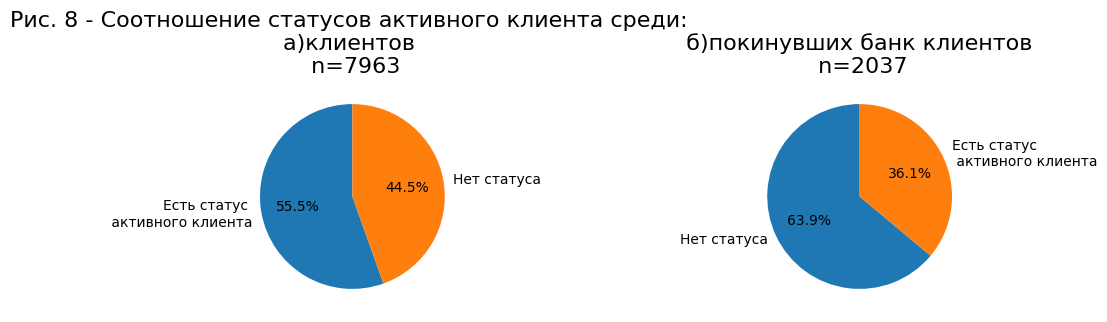

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3)) 
labels = 'Есть статус \n активного клиента', 'Нет статуса'
labels1 =  'Нет статуса', 'Есть статус \n активного клиента'

# круговая даиграмма 1 с помощью библиотеки matplotlib
ax1.pie(
    churn_df[churn_df['client status'] == 'Клиент']['IsActiveMember'].value_counts().sort_values(ascending=False),
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
)

ax1.set_title('Рис. 8 - Cоотношение статусов активного клиента среди: \nа)клиентов \n n=7963', fontsize=16)

# круговая даиграмма 2 с помощью библиотеки matplotlib
ax2.pie(
    churn_df[churn_df['client status'] == 'Покинул банк']['IsActiveMember'].value_counts().sort_values(ascending=False),
    labels=labels1,
    autopct='%1.1f%%',
    startangle=90,
)

ax2.set_title('  \n б)покинувших банк клиентов \n n=2037', loc='center', fontsize=16);

На рис.8 изображены диаграммы, показывающие клиентов с ушедшими клиетами по статусу активного клиента. Анализируя диаграммы, можно сделать следующий вывод:
* среди клиентов банка больше тех, которые имеют статус.
* среди покинувших банк клиентов больше "пассивных" - тех, которые не имели статуса. В связи с этим, можно порекоммендовать банку активнее выявлять потребности "пассивных" клиентoв и предлагать им соответствующие услуги.

# Задание 9
----------
В какой стране доля ушедших клиентов больше? Постройте тепловую картограмму, которая покажет это соотношение на карте мира. Предположите, с чем это может быть связано.

In [11]:
#данные
df = churn_data.groupby(['Geography'], as_index=False).mean(numeric_only=True)
#Количество 
#churn_df[churn_df['Exited']==1].groupby(['Exited','Geography'] , as_index=False).count() 

# построим картограмму с помощью библиотеки Plotly
fig = px.choropleth(
    df,
    locations="Geography",
    locationmode = "country names",
    color='Exited', #CustomerId
    title='Рис. 9 - Распределение ушедших клиентов по странам', 
    width=800,
    height=400,
    color_continuous_scale="Burg",
    labels={'Exited':'Покинувшие банк клиенты'}
)
fig.update_layout(title_font_size=16)
#fig.show()
fig.write_image('../figures/fig_9.png', engine="kaleido")

<center> <img src = "../figures/fig_9.png"> </center>

На рис.9 изображена диаграмма распределения ушедших клиентов по странам. Анализируя диаграмму отметим, что больше всего клиентов, 32.4%, покинуло немецкий филиал банка. Французский испанский филиалы банка покинуло примерно 16% кдиентов.
Принимая во внимание предыдущие диаграммы отметим, что кдиентам среднего возраста с высокой зарплатой из Германии и могло не понравитья особенности начисления кредитного рейтинга. Возможно, что из-за этого они начали активно пользоваться кредитной программой и не получили статус "активного клиента".

# Задание 10
----------
Переведите числовой признак CreditScore в категориальный. Для этого воспользуйтесь функцией get_credit_score_cat(), которая приведена ниже. Примените её к столбцу CreditScore и создайте новый признак CreditScoreCat — категории кредитного рейтинга.

Постройте сводную таблицу, строками которой являются категории кредитного рейтинга (CreditScoreCat), а столбцами — количество лет, в течение которых клиент пользуется услугами банка (Tenure). В ячейках сводной таблицы должно находиться среднее по признаку оттока (Exited) — доля ушедших пользователей.

На основе полученной сводной таблицы постройте тепловую карту с аннотацией. Найдите на тепловой карте категории клиентов, которые уходят чаще всего.

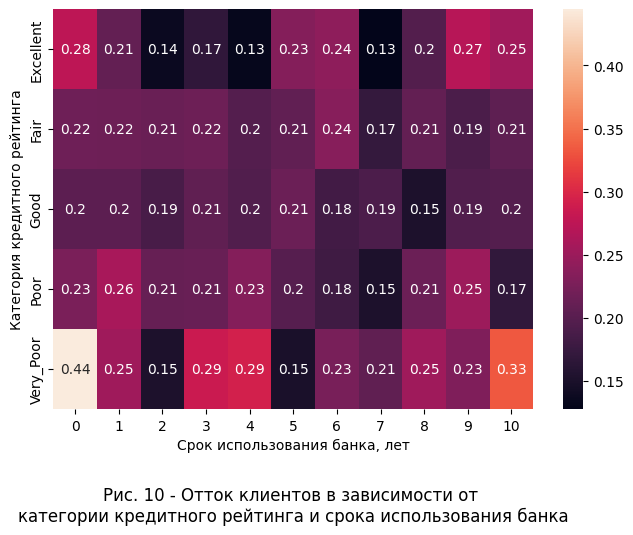

In [12]:
#функция распределения кредитного рейтинга на 5 групп по его значению
def get_credit_score_cat(credit_score):
    if credit_score >= 300 and credit_score < 500:
        return "Very_Poor"
    elif credit_score >= 500 and credit_score < 601:
        return "Poor"
    elif credit_score >= 601 and credit_score < 661:
        return "Fair"
    elif credit_score >= 661 and credit_score < 781:
        return "Good"
    elif credit_score >= 781 and credit_score < 851:
        return "Excellent"
    elif credit_score >= 851:
        return "Top"
    elif credit_score < 300:
        return "Deep"
    
# Отобразим результат в графе 'CreditScoreCat'
churn_df['CreditScoreCat'] = churn_df['CreditScore'].apply(get_credit_score_cat) 

fig = plt.figure(figsize=(6, 4))
ax = fig.add_axes((0, 0, 1, 1))

#данные
df = churn_df.pivot_table(values='Exited', index='CreditScoreCat', columns='Tenure', aggfunc='mean')

# строим тепловую диаграму с помощью библиотеки Seaborn. Параметр 'annot=True' показывает значения на диаграмме
sns.heatmap(df, annot=True ); #linewidths=.05

ax.set_title('Рис. 10 - Отток клиентов в зависимости от \nкатегории кредитного рейтинга и срока использования банка', fontsize=12, y=-0.3)
ax.set_xlabel('Срок использования банка, лет')
ax.set_ylabel('Категория кредитного рейтинга');

plt.savefig(f'../figures/fig_10.png')

На рис.10 изображена диаграмма оттока клиентов в зависимости от категории кредитного рейтинга и срока использования банка. Анализируя диаграмму, можно сделать следующие выводы:
* у клиеентов с очень низким кредитным рейтингом('very_poor') наблюдается максимальный отток (в порядке убывания интенсивности) втечение : 1, 4 и 5 года пользования банком. Возможно, уход клиентов обусловлен следующими мотивами: разочарование от низкой величиной кредитного рейтинга у вновь пришедших клиентов, которое ежегодно уменьшается в половину по мере использования кредитной программы. На 4 и 5 году это неприятие вновь увеличивается и разочарованные клиенты уходят. С 6-го года клиенты привыкают к условиям программы, но недовольство ею остаётся вплоть до 11-го года пользования банком.
* у клиентов с рейтингами 'poor', 'good', 'fair' не наблюдается значительных колебаний оттока
* у клиентов с рейтингом группы 'excellent' наблюдается схожая картина оттока по сравнению с группой 'very_poor', но интенсивность её меньше. Максимумы оттока наблюдаются на 1 и 10 и 11 годах. Также всплеск отток наблюдается в середине периода использования банка на 6 и 7 году - т.е. со смещением в 1 год позже  (по сравнению с группой 'very_poor'.

# Задача 11. Построение тепловой карты корреляции
---

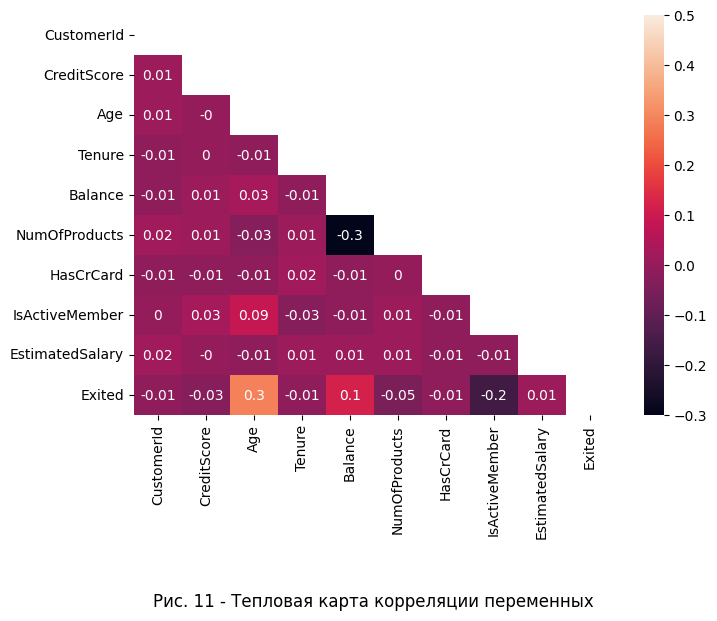

In [13]:
# Удалим повторяющийся признак
churn_df.drop(['client status', 'CreditScoreCat'], axis=1, inplace=True)

fig = plt.figure(figsize=(6, 4))
ax = fig.add_axes((0, 0, 1, 1))
matrix = np.triu(churn_df.corr(numeric_only=True))

fig = sns.heatmap(churn_df.corr(numeric_only=True).round(2), annot=True, fmt='.1g', vmax=0.5, mask=matrix) #, vmax=0.3
ax.set_title('Рис. 11 - Тепловая карта корреляции переменных', fontsize=12, y=-0.5);

На рис. 11 изображена тепловая карта корреляции переменных между собой. Чем больше абсолютная величина коэффициента корреляции переменной в ячейке, тем сильнее взаимосвязь переменных соответственно. Анализируя диаграмму можно сделать следующие выводы:
* максимальная положительная связь усматривается между возрастом клиента и его статусом пользования банком;
* максимальная отрицательная связь между балансом и количеством услуг банка. Иными словами: чем больше баланс клиента- тем меньшим количеством услуг банка он пользуется.

В модуле по визуализации мы выяснили, что отток клиентов в Германии, Франции и Испании имеет различные показатели. Исследователи, которые уже работали с этим датасетом, пришли к выводу, что наилучшее решение при работе с этими данными — строить модели индивидуально для каждой страны. Мы будем прогнозировать отток в немецком филиале банка. Давайте выделим только данные, относящиеся к Германии:

In [14]:
churn_data_cleaned = churn_df[churn_df['Geography'] == 'Germany']
print('Shape:', churn_data_cleaned.shape)
# (2509, 14)
churn_data_cleaned.head()

Shape: (2509, 14)


,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Пол
7,15656148,Obinna,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1,0
15,15643966,Goforth,616,Germany,Male,45,3,143129.41,2,0,1,64327.26,0,1
16,15737452,Romeo,653,Germany,Male,58,1,132602.88,1,1,0,5097.67,1,1
26,15736816,Young,756,Germany,Male,36,2,136815.64,1,1,1,170041.95,0,1
28,15728693,McWilliams,574,Germany,Female,43,3,141349.43,1,1,1,100187.43,0,0


Сразу избавимся от заведомо неинформативных признаков: страна, номер строки, идентификатор пользователя и имя клиента.

In [15]:
churn_data_cleaned = churn_data_cleaned.drop(['CustomerId', 'Surname', 'Geography', 'Gender'], axis=1).rename(columns={'Пол':'Gender'}) #delete and rename features
print('Shape:', churn_data_cleaned.shape)
churn_data_cleaned.head()

Shape: (2509, 10)


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Gender
7,376,29,4,115046.74,4,1,0,119346.88,1,0
15,616,45,3,143129.41,2,0,1,64327.26,0,1
16,653,58,1,132602.88,1,1,0,5097.67,1,1
26,756,36,2,136815.64,1,1,1,170041.95,0,1
28,574,43,3,141349.43,1,1,1,100187.43,0,0


Проверим, что в наших данных нет пропусков:

In [16]:
churn_data_cleaned.isnull().sum()

CreditScore        0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
Gender             0
dtype: int64

Давайте расширим наш датасет с помощью методов Feature Engineering. Создадим следующие признаки:

* BalanceSalaryRatio — отношение баланса на счетах к заработной плате клиента;
* TenureByAge — отношение времени пользования банком к возрасту клиента;
* CreditScoreGivenAge — отношение кредитного рейтинга к возрасту клиента.

Также перекодируем единственный текстовый категориальный признак Gender в бинарный столбец (1 — 'Male', 0 — 'Female'):

In [17]:
churn_data_cleaned['BalanceSalaryRatio'] = churn_data_cleaned['Balance']/churn_data_cleaned['EstimatedSalary']
churn_data_cleaned['TenureByAge'] = churn_data_cleaned['Tenure']/(churn_data_cleaned['Age'])
churn_data_cleaned['CreditScoreGivenAge'] = churn_data_cleaned['CreditScore']/(churn_data_cleaned['Age'])

churn_data_cleaned.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Gender,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge
7,376,29,4,115046.74,4,1,0,119346.88,1,0,0.963969,0.137931,12.965517
15,616,45,3,143129.41,2,0,1,64327.26,0,1,2.225020,0.066667,13.688889
16,653,58,1,132602.88,1,1,0,5097.67,1,1,26.012449,0.017241,11.258621
26,756,36,2,136815.64,1,1,1,170041.95,0,1,0.804599,0.055556,21.000000
28,574,43,3,141349.43,1,1,1,100187.43,0,0,1.410850,0.069767,13.348837


Разделим набор данных на матрицу наблюдений X и столбец ответов y:

In [18]:
X = churn_data_cleaned.drop("Exited", axis=1)
y = churn_data_cleaned["Exited"]

Проведём нормализацию матрицы наблюдений X:

In [19]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

Посмотрим на сбалансированность данных. Для этого воспользуемся методом value_counts() и выведем количество наблюдений каждого из классов в долевом соотношении от общего количества наблюдений:

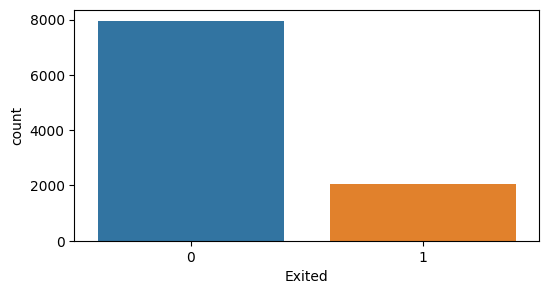

In [20]:
y.value_counts(normalize=True)

fig = plt.figure(figsize=(6, 3))
sns.countplot(data = churn_data, x='Exited');

При разделении нашего набора данных на тренировочный и тестовый может возникнуть такая ситуация, что в тренировочную выборку попадут только лояльные клиенты или их большая часть. Тогда модель может не научиться определять вероятность оттока и качество на тестовой выборке будет оставлять желать лучшего. Или противоположная ситуация: в тестовую выборку попадут только лояльные клиенты. Тогда модель будет показывать прекрасное качество на тестовой выборке, но в реальных условиях она может оказаться бесполезной.

То есть нам нужно сделать так, чтобы в тренировочной и тестовой выборках было одинаковое соотношение лояльных и ушедших клиентов. Такое разбиение выборки называется **стратифицированным**. 

Выполним разбиение, установив значением параметра random_state число 0:

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, random_state=0) #random_seed

print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))


Train shape: (1881, 12)
Test shape: (628, 12)


Проверим, что число лояльных и ушедших клиентов примерно одинаково в каждой из выборок:

In [22]:
print('Train :\n', y_train.value_counts(normalize=True).round(2))
print('\n')
print('Test :\n', y_test.value_counts(normalize=True).round(2))

Train :
 0    0.68
1    0.32
Name: Exited, dtype: float64


Test :
 0    0.68
1    0.32
Name: Exited, dtype: float64


## Моделирование + оценка модели

В данной задаче нам нужен баланс между $precision$ и $recall$, поэтому мы будем использовать $F1$-меру.

### Логистическая регрессия

In [23]:
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(
    solver='sag', #алгоритм оптимизации 
    random_state=0, #генератор случайных чисел
    max_iter=1000 #количество итераций на сходимость
)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=0, solver='sag')

In [24]:
#Делаем предсказание для тренировочной выборки
y_train_pred = log_reg.predict(X_train)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_train, y_train_pred))
#Делаем предсказание для тестовой выборки
y_test_pred = log_reg.predict(X_test)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_test, y_test_pred))

print('F1 score for train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('F1 score for test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

              precision    recall  f1-score   support

           0       0.76      0.89      0.82      1271
           1       0.63      0.40      0.49       610

    accuracy                           0.73      1881
   macro avg       0.69      0.64      0.65      1881
weighted avg       0.72      0.73      0.71      1881

              precision    recall  f1-score   support

           0       0.75      0.89      0.81       424
           1       0.63      0.38      0.47       204

    accuracy                           0.72       628
   macro avg       0.69      0.63      0.64       628
weighted avg       0.71      0.72      0.70       628

F1 score for train: 0.49
F1 score for test: 0.47


### Полиноминальная регрессия 3 степени

In [25]:
#Создаём генератор полиномиальных признаков
poly = preprocessing.PolynomialFeatures(degree=3, include_bias=False)
poly.fit(X_train)
#Генерируем полиномиальные признаки для тренировочной выборки
X_train_poly = poly.transform(X_train)
#Генерируем полиномиальные признаки для тестовой выборки
X_test_poly = poly.transform(X_test)
#Выводим результирующие размерности таблиц
print(X_train_poly.shape)
print(X_test_poly.shape)

print(f'Кол-во признаков в тренировочной выборке:',X_train_poly.shape[1])

(1881, 454)
(628, 454)
Кол-во признаков в тренировочной выборке: 454


In [26]:
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(
    solver='sag', #алгоритм оптимизации
    random_state=42, #генератор случайных чисел
    max_iter=1000 #количество итераций на сходимость
)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train_poly, y_train)

LogisticRegression(max_iter=1000, random_state=42, solver='sag')

In [27]:
#Выводим отчет по метрикам для тренировочной и тестовой выборок
#Делаем предсказание для тренировочной выборки
y_train_pred = log_reg.predict(X_train_poly)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_train, y_train_pred))
#Делаем предсказание для тестовой выборки
y_test_pred = log_reg.predict(X_test_poly)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_test, y_test_pred))

print('F1-score в тренировочной выборке: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('F1-score в тренировочной выборке: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

              precision    recall  f1-score   support

           0       0.82      0.92      0.87      1271
           1       0.78      0.56      0.66       610

    accuracy                           0.81      1881
   macro avg       0.80      0.74      0.76      1881
weighted avg       0.80      0.81      0.80      1881

              precision    recall  f1-score   support

           0       0.81      0.90      0.85       424
           1       0.73      0.56      0.64       204

    accuracy                           0.79       628
   macro avg       0.77      0.73      0.75       628
weighted avg       0.79      0.79      0.78       628

F1-score в тренировочной выборке: 0.66
F1-score в тренировочной выборке: 0.64


### Оптимизация порога вероятности полиноминальной модели

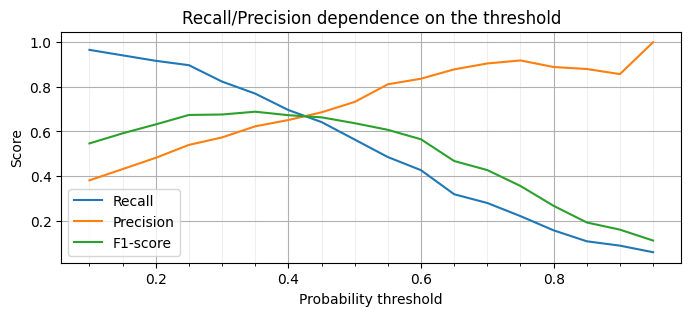

In [36]:
#Считаем вероятности оттока клиентов
y_test_proba_pred = log_reg.predict_proba(X_test_poly)[:, 1]
#Для удобства завернем numpy-массив в pandas Series
y_test_proba_pred = pd.Series(y_test_proba_pred)
#Создадим списки, в которых будем хранить значения метрик 
recall_scores = []
precision_scores = []
f1_scores = []
#Сгенерируем набор вероятностных порогов в диапазоне от 0.1 до 1
thresholds = np.arange(0.1, 1, 0.05)
#В цикле будем перебирать сгенерированные пороги
for threshold in thresholds:
    #Пациентов, для которых вероятность наличия диабета > threshold относим к классу 1
    #В противном случае - к классу 0
    y_test_pred = y_test_proba_pred.apply(lambda x: 1 if x>threshold else 0)
    #Считаем метрики и добавляем их в списки
    recall_scores.append(metrics.recall_score(y_test, y_test_pred))
    precision_scores.append(metrics.precision_score(y_test, y_test_pred))
    f1_scores.append(metrics.f1_score(y_test, y_test_pred))

#Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(8, 3)) #фигура + координатная плоскость
#Строим линейный график зависимости recall от threshold
ax.plot(thresholds, recall_scores, label='Recall')
#Строим линейный график зависимости precision от threshold
ax.plot(thresholds, precision_scores, label='Precision')

# Major ticks every 20, minor ticks every 5
#major_ticks = np.arange(0, 101, 20)
minor_ticks = np.arange(0, 1, 0.05)
ax.set_xticks(minor_ticks, minor=True)

#Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, f1_scores, label='F1-score')
#Даем графику название и подписи осям
ax.set_title('Recall/Precision dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
#Отображаем легенду
ax.legend()
ax.grid()
ax.grid(which='minor', alpha=0.2);

Мы видим на графике:

С увеличением вероятностного порога (treshhold) повышается precision и падает recall. Это означает, что при увеличении порога вероятности мы начинаем классифицировать в качестве "уходящих" тех клиентов клиентов, признаки которых чётче указывают на желание покинуть банк. Таким образом, повышая точность (precision) мы уменьшаем охват (recall).

При этом значение $F1$-меры сначала немного повышается, а затем неуклонно падает. 

В точке threshold=0.43 происходит пересечение всех трёх графиков.  

Однако максимум  $F1$-меры достигается в другой точке — threshold=0.3. При этом значения recall и precision в этой точке различны: recall выше, а вот precision ниже.

In [29]:
thresholds_scores_df = pd.DataFrame({'thresh':thresholds, 'f1-scores':f1_scores}) #.reset_index()
thresholds_scores_df.sort_values(by='f1-scores', ascending=False).head(1)

,thresh,f1-scores
5,0.35,0.688596


In [30]:
best = pd.DataFrame({'thresh':thresholds, 'precision_scores':precision_scores, 'recall_scores':recall_scores}) #.reset_index()
best['best_score'] = best['precision_scores'] - best['recall_scores']
best[['thresh', 'best_score']]

,thresh,best_score
0,0.10,-0.584642
1,0.15,-0.509716
2,0.20,-0.434708
3,0.25,-0.357236
4,0.30,-0.250151
5,0.35,-0.146592
6,0.40,-0.044702
7,0.45,0.043707
8,0.50,0.168759
9,0.55,0.326181


In [31]:
#Задаем оптимальный порог вероятностей
threshold_opt = 0.35
#Пациентов, для которых вероятность наличия диабета > 0.35 относим к классу 1
#В противном случае - к классу 0
y_pred_opt = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
#Считаем метрики
print(metrics.classification_report(y_test, y_pred_opt))

              precision    recall  f1-score   support

           0       0.89      0.71      0.79       424
           1       0.57      0.82      0.68       204

    accuracy                           0.74       628
   macro avg       0.73      0.76      0.73       628
weighted avg       0.79      0.74      0.75       628



### Модель Дерево решений

In [32]:
#Создаём объект класса DecisionTreeClassifier
dt = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности 
    max_depth=8, #максимальная глубина
    min_samples_leaf = 10, # Минимальное число объектов в листе
    random_state=random_seed #генератор случайных чисел
)
#Обучаем дерево решений по алгоритму CART
dt.fit(X_train, y_train)

#Делаем предсказание класса для тренировочной выборки
y_pred_train = dt.predict(X_train)
#Выводим отчет о метриках
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_pred_train)))

#Делаем предсказание класса для тестовой выборки
y_pred_test = dt.predict(X_test)
#Выводим отчет о метриках
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_pred_test)))

Train: 0.72
Test: 0.65


### Случайный лес

In [33]:
#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(
    n_estimators=400, #число деревьев
    criterion='entropy', #критерий эффективности
    max_depth=8, #максимальная глубина дерева
    min_samples_leaf = 10, # Минимальное число объектов в листе
    #max_features='sqrt', #число признаков из метода случайных подространств
    random_state=random_seed #генератор случайных чисел
)
#Обучаем модель 
rf.fit(X_train, y_train)

#Делаем предсказание класса для тренировочной выборки
y_pred_train = rf.predict(X_train)
#Выводим отчет о метриках
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_pred_train)))

#Делаем предсказание класса для тестовой выборки
y_pred_test = rf.predict(X_test)
#Выводим отчет о метриках
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_pred_test)))

Train: 0.73
Test: 0.65


In [34]:
#Считаем вероятности оттока клиентов модели случайный лес
y_test_proba_pred = rf.predict_proba(X_test)[:, 1]
#Для удобства завернем numpy-массив в pandas Series
y_test_proba_pred = pd.Series(y_test_proba_pred)

#Задаем оптимальный порог вероятностей
threshold_opt = 0.35
#Клиентов, для которых вероятность оттока > threshold относим к классу 1. В противном случае - к классу 0
y_pred_opt = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
#Считаем метрики
print(metrics.classification_report(y_test, y_pred_opt))
print('F1-score:', metrics.f1_score(y_test, y_pred_opt).round(3))

              precision    recall  f1-score   support

           0       0.88      0.78      0.83       424
           1       0.63      0.77      0.69       204

    accuracy                           0.78       628
   macro avg       0.75      0.78      0.76       628
weighted avg       0.80      0.78      0.78       628

F1-score: 0.693


Выводы: